In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import glob
import os

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models
import urllib.request
import scipy.io as io
import h5py
import progressbar

In [ ]:
train_subjects= ['tr03-0333',
                 'tr03-0373',
                 'tr03-0532',
                 'tr03-1183',
                 'tr04-0332',
                 'tr05-0827',
                 'tr05-1042',
                 'tr06-0447']

In [ ]:
test_subjects = ['tr03-1129', 'tr06-1010']
val_subjects = ['tr03-0100','tr07-0605']

# Data

In [ ]:
labelURL = 'https://physionet.org/files/challenge-2018/1.0.0/training/' + 'tr03-0100' + '/' + 'tr03-0100'+ '.mat?download'
urllib.request.urlretrieve(labelURL, '/content/data.mat')

('/content/data.mat', <http.client.HTTPMessage at 0x7f956bf34dd0>)

In [ ]:
data = io.loadmat('/content/data.mat')
data = data['val']
data

array([[     7,      3,     -2, ...,      0,      0,      0],
       [    -6,     -6,     -5, ...,      0,      0,      0],
       [     7,      3,      0, ...,      0,      0,      0],
       ...,
       [  -365,   -388,   -418, ...,  -1091,  -1091,  -1090],
       [ 30496,  30496,  30496, ..., -32443, -32443, -32443],
       [   183,    150,    210, ...,    -18,    -20,    -20]], dtype=int16)

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def serialize_example(data, target):
  feature = {
      'data': _bytes_feature(data),
      'target': _bytes_feature(target)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()


In [ ]:
!mkdir /content/data

In [ ]:
#!rm -r /content/data/val

In [ ]:
def create_tfrecs(subjects_lists, save_path = '/content/data'):
  i = 0
  num_all = 0
  with progressbar.ProgressBar(max_value=len(subjects_lists)) as bar:
    for rec in subjects_lists:
      labelURL = 'https://physionet.org/files/challenge-2018/1.0.0/training/' + rec + '/' + rec+ '.mat?download'
      urllib.request.urlretrieve(labelURL, '/content/data.mat')

      data = io.loadmat('/content/data.mat')
      data = data['val']
      data = data.astype(np.int16)
      number_of_arrays = data.shape[1]//256
      num_all = num_all + number_of_arrays
      with tf.io.TFRecordWriter(os.path.join(save_path, rec + '.tfrec')) as writer:
        for j in range(number_of_arrays):
          sub_data = data[0:6,j*256:(j+1)*256]
          sub_data = sub_data.astype(np.int16)
          sub_data = sub_data.reshape(256,6)
          target = data[10,j*256:(j+1)*256]
          target = target.astype(np.int16)
          target = target.reshape(256,1)

          example = serialize_example(sub_data.tostring(), target.tostring())
          writer.write(example)
      i +=1
      bar.update(i)
  return num_all

In [ ]:
save_path = '/content/data/train'
if not os.path.isdir(save_path):
  os.mkdir(save_path)
num_train_samples = create_tfrecs(train_subjects, save_path = save_path)
num_train_samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100% (8 of 8) |##########################| Elapsed Time: 0:00:52 Time:  0:00:52


165405

In [ ]:
save_path = '/content/data/test'
if not os.path.isdir(save_path):
  os.mkdir(save_path)
num_test_samples = create_tfrecs(test_subjects, save_path = save_path)
num_test_samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100% (2 of 2) |##########################| Elapsed Time: 0:00:10 Time:  0:00:10


48522

In [ ]:
save_path = '/content/data/val'
if not os.path.isdir(save_path):
  os.mkdir(save_path)
num_val_samples = create_tfrecs(val_subjects, save_path = save_path)
num_val_samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100% (2 of 2) |##########################| Elapsed Time: 0:00:12 Time:  0:00:12


44048

# Generator

In [ ]:
# Create a dictionary describing the features.
feature_description = {
    'data': tf.io.FixedLenFeature([], tf.string, ''),
    'target': tf.io.FixedLenFeature([], tf.string, ''),
  }

def _parse_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def preprocess(features,effesionet=True):
  data = features['data']
  data = tf.io.decode_raw(data, tf.int16)
  label = features['target']
  label = tf.io.decode_raw(label, tf.int16)
  return data, label


def normalize(data ,label):
  #standard
  data = tf.cast(data, tf.float32)
  scale = tf.constant([5895.0,5806.0,5776.0,5776.0,5953.0,6018.0]) - tf.constant([-4920.0,-4888.0,-4823.0,-4891.0,-5023.0,-4981.0])
  offset = tf.constant([-4920.0,-4888.0,-4823.0,-4891.0,-5023.0,-4981.0])

  data -= offset
  data /= scale

  label = tf.cast(label, tf.float32)
  scale =  tf.constant([5983.0]) + tf.constant([5815.0])
  offset = tf.constant([-5815.0])
  label -= offset
  label /= scale
  return data , label

@tf.function
def augment(data,label):

  return data , label

def Resize(data,label):
  data = tf.reshape(data, [256,6])
  label = tf.reshape(label, [256,1])
  return data , label


In [ ]:
BATCH_SIZE = 256
train_tfrecs = glob.glob(os.path.join('/content/data/train', '*.tfrec'))
ds_train = tf.data.TFRecordDataset([train_tfrecs])
ds_train = ds_train.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).prefetch(100)
ds_train  =  ds_train.map(preprocess)#.map(agment)
ds_train  = ds_train.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [ ]:
BATCH_SIZE = 256
val_tfrecs = glob.glob(os.path.join('/content/data/val', '*.tfrec'))
ds_val= tf.data.TFRecordDataset([val_tfrecs])
ds_val = ds_val.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val  =  ds_val.map(preprocess)
ds_val  = ds_val.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [ ]:
data1, label = next(iter(ds_train))
data1.shape

TensorShape([512, 256, 6])

In [ ]:
label.shape

TensorShape([512, 256, 1])

In [ ]:
label.shape

TensorShape([512, 256, 1])

In [ ]:
np.std(data1.numpy())

0.0026272633

## data Statistics

In [ ]:
def find_stats(path_to_tfrecs = '/content/data/train'):
  all_tfrecs = glob.glob(os.path.join(path_to_tfrecs, '*.tfrec'))
  ds_stat= tf.data.TFRecordDataset(all_tfrecs)
  ds_stat = ds_stat.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(100)
  ds_stat  =  ds_stat.map(preprocess)
  ds_stat  = ds_stat.map(Resize).batch(1024,drop_remainder=True)

  mean_data = np.zeros((6,))
  std_data = np.zeros((6,))
  max_data = np.ones((6,))*-100000 # -inf
  min_data = np.ones((6,))*(100000) #+inf

  mean_label = 0
  std_label = 0
  max_label = -100000000000
  min_label = 10000000000
  k = 0
  for i in ds_stat:
    data1, label = i
    mean_data = mean_data + np.mean(np.mean(data1.numpy(),axis=1),axis=0)
    std_data = std_data + np.std(np.std(data1.numpy(),axis=1),axis=0)
    mean_label = mean_label + np.mean(np.mean(label.numpy(),axis=1),axis=0)
    std_label = std_label + np.std(np.std(label.numpy(),axis=1),axis=0)

    data =np.max(np.max(data1,axis=1),axis=0)
    max_data[np.where(max_data< data)] = data[np.where(max_data< data)]
    data =np.min(np.min(data1,axis=1),axis=0)
    min_data[np.where(min_data> data)] = data[np.where(min_data> data)]

    if np.max(np.max(label,axis=1))>max_label:
      max_label = np.max(np.max(label,axis=1))
    if np.min(np.min(label))<min_label:
      min_label = np.min(np.min(label))

    k = k+1
  std_data = std_data/k
  mean_data = mean_data/k
  mean_label = mean_label/k
  std_label = std_label/k
  print('min data')
  print(min_data)
  print('max data')
  print(max_data)
  print('std data')
  print(std_data)
  print('mean data')
  print(mean_data)

  print('std label')
  print(std_label)
  print('mean label')
  print(mean_label)
  print('min label')
  print(min_label)
  print('max label')
  print(max_label)
  del ds_stat

In [ ]:
find_stats(path_to_tfrecs = '/content/data/train')

min data
[-4920. -4888. -4823. -4891. -5023. -4981.]
max data
[5895. 5806. 5776. 5776. 5953. 6018.]
std data
[32.14767588 32.16229526 32.16266134 32.14734267 32.15284611 32.14887678]
mean data
[-1.16639700e-03  2.69872061e-05  1.02086985e-03  8.04948511e-04
 -1.13903069e-03 -2.18965992e-03]
std label
[26.33745199 26.33745199 26.33745199 26.33745199 26.33745199 26.33745199]
mean label
[-0.04896538 -0.04896538 -0.04896538 -0.04896538 -0.04896538 -0.04896538]
min label
-5815
max label
5983


In [ ]:
find_stats(path_to_tfrecs = '/content/data/test')

std data
[33.45443841 33.44310772 33.47373585 33.46568839 33.50312653 33.5066234 ]
mean data
[-5.34057617e-04 -4.46725399e-04 -1.33027422e-04 -1.65574094e-05
  2.83748546e-04  2.84397856e-04]
std label
[122.25492895 122.25492895 122.25492895 122.25492895 122.25492895
 122.25492895]
mean label
[0.00411184 0.00411184 0.00411184 0.00411184 0.00411184 0.00411184]


In [ ]:
find_stats(path_to_tfrecs = '/content/data/val')

std data
[24.16726437 24.15298652 24.13948546 24.13555023 24.19395974 24.21279692]
mean data
[-2.30212544e-04  5.72204590e-05  1.14352204e-04 -9.73191372e-05
  6.24545785e-05  1.77427780e-06]
std label
[125.25283794 125.25283794 125.25283794 125.25283794 125.25283794
 125.25283794]
mean label
[0.49395113 0.49395113 0.49395113 0.49395113 0.49395113 0.49395113]


# model

In [ ]:
from tensorflow.keras.activations import selu, relu

class BB (tf.keras.layers.Layer):
  def __init__(self,
               filters = 64,
               kernel_size = 9):
    super(BB, self).__init__()

    self.filters = filters
    self.kernel_size = kernel_size

    self.conv1 = tf.keras.layers.Conv1D(filters, kernel_size, activation=None, padding='same')

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv1D(filters, kernel_size, activation=None, padding='same')


  def call(self, z, training = True):
    x = self.conv1(z)
    x = self.bn1(x, training = training)
    x = selu(x)

    x = self.conv2(x)
    x = self.bn2(x, training = training)
    x = selu(x)
    x = tf.keras.layers.Add()([x, z])

    x = self.bn3(x, training = training)
    x = selu(x)
    return x

In [ ]:
def tf_max_pool_with_masks(x,
                           ksize = [1,1,2,1],
                           strides = [1,1,2,1],
                           padding = "VALID",
                           data_format='NHWC',
                           output_dtype=tf.dtypes.int64,
                           include_batch_in_index=True):
  """
    x = input tensor of size BTC, B=Batch, T:Time step, C:Channel
    ksize: kernel size for each dim
    strides: strides of each dim
    data_format:channel last or not
    output_dtype: int64 or int32
    include_batch_in_index:An optional boolean. Defaults to True. Whether to include batch dimension in flattened index of argmax.
  """
  input = tf.reshape(x, shape=(x.shape[0], 1, x.shape[1],x.shape[2]))
  output, argmax = tf.nn.max_pool_with_argmax(input,
                                              ksize = ksize,
                                              strides = strides,
                                              padding = "VALID",
                                              data_format='NHWC',
                                              output_dtype=tf.dtypes.int64,
                                              include_batch_in_index=True
                                              )

  #a = tf.reshape(output, shape=(-1,1))
  indices = tf.reshape(argmax, shape=(-1,1))
  input_flatten = tf.reshape(input, shape=(-1,1))
  tensor = tf.zeros_like(input_flatten, dtype=tf.float32)
  updates = tf.ones_like(indices, dtype=tf.float32)
  mask = tf.tensor_scatter_nd_update(tensor, indices, updates)
  mask = tf.reshape(mask, shape=x.get_shape().as_list())
  output = tf.reshape(output, shape=(output.shape[0],output.shape[2],output.shape[3]))
  return output, mask

In [ ]:
x = tf.constant(1.0, dtype=tf.float32, shape=(16,16,512))*np.random.rand()

In [ ]:
a,b = tf_max_pool_with_masks(x)

In [ ]:
a.shape

TensorShape([16, 8, 512])

In [ ]:
b.shape

TensorShape([16, 16, 512])

In [ ]:
from tensorflow import keras

class eUNet1D (keras.Model):
  def __init__(self,
               kernel_size = 9,
               strides = 2):
    super(eUNet1D, self).__init__()
    self.kernel_size        = kernel_size
    self.strides            = strides
    self.conv1_0 = tf.keras.layers.Conv1D(64, kernel_size, activation='selu', padding='same')
    self.bb1_1 = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb1_2 = BB(filters = 64, kernel_size = self.kernel_size)

    #self.down2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv2_0 = tf.keras.layers.Conv1D(128, kernel_size, activation='selu', padding='same')
    self.bb2_1 = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb2_2 = BB(filters = 128, kernel_size = self.kernel_size)

    #self.down3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv3_0 = tf.keras.layers.Conv1D(256, kernel_size, activation='selu', padding='same')
    self.bb3_1 = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb3_2 = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb3_3 = BB(filters = 256, kernel_size = self.kernel_size)

    #self.down4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv4_0 = tf.keras.layers.Conv1D(512, kernel_size, activation='selu', padding='same')
    self.bb4_1 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb4_2 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb4_3 = BB(filters = 512, kernel_size = self.kernel_size)

    #self.down5 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.bb5_1 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_2 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_3 = BB(filters = 512, kernel_size = self.kernel_size)

    self.bb5_1_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_2_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_3_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.up5 =  tf.keras.layers.Conv1DTranspose(filters = 512, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv4_0_ = tf.keras.layers.Conv1D(256, kernel_size, activation='selu', padding='same')
    self.bb4_1_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb4_2_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb4_3_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.up4 =  tf.keras.layers.Conv1DTranspose(filters = 256, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv3_0_ = tf.keras.layers.Conv1D(128, kernel_size, activation='selu', padding='same')
    self.bb3_1_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb3_2_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb3_3_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.up3 =  tf.keras.layers.Conv1DTranspose(filters = 128, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv2_0_ = tf.keras.layers.Conv1D(64, kernel_size, activation='selu', padding='same')
    self.bb2_1_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb2_2_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.up2 =  tf.keras.layers.Conv1DTranspose(filters = 64, kernel_size = 2, strides=self.strides, padding='valid')

    self.bb1_1_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb1_2_ = BB(filters = 64, kernel_size = self.kernel_size)
    #self.up1 =  tf.keras.layers.Conv1DTranspose(filters = 64, kernel_size = 2, strides=self.strides, padding='same')
    self.conv_out = tf.keras.layers.Conv1D(1, 1, activation='relu')



  def call(self, z, training = True):
    """
      z: (btach, time steps, channels)--> input
    """
    #######################################
    ############ Row 1 ####################
    #######################################
    x = self.conv1_0(z)#(None, 256, 64)
    x = self.bb1_1(x) #(None, 256, 64)
    x1 = self.bb1_2(x) #(None, 256, 64)

    #######################################
    ############ Row 2 ####################
    #######################################
    x, mask2 = tf_max_pool_with_masks(x1) #(None, 128, 64)
    x = self.conv2_0(x)
    x = self.bb2_1(x) #(None, 128, 128)
    x2 = self.bb2_2(x) #(None, 128, 128)

    #######################################
    ############ Row 3 ####################
    #######################################
    x, mask3 = tf_max_pool_with_masks(x2) #(None, 64, 128)
    x = self.conv3_0(x)
    x = self.bb3_1(x) #(None, 64, 256)
    x = self.bb3_2(x) #(None, 64, 256)
    x3 = self.bb3_3(x) #(None, 64, 256)

    #######################################
    ############ Row 4 ####################
    #######################################
    x, mask4 = tf_max_pool_with_masks(x3) #(None, 32, 256)
    x = self.conv4_0(x)
    x = self.bb4_1(x) #(None, 32, 512)
    x = self.bb4_2(x) #(None, 32, 512)
    x4 = self.bb4_3(x) #(None, 32, 512)

    #######################################
    ############ Row 5 ####################
    #######################################
    x, mask5 = tf_max_pool_with_masks(x4) #(None, 16, 512)
    x = self.bb5_1(x) #(None, 16, 512)
    x = self.bb5_2(x) #(None, 16, 512)
    x = self.bb5_3(x) #(None, 16, 512)

    #######################################
    ############ Row 5_1 ##################
    #######################################
    x = self.bb5_1_(x) #(None, 16, 512)
    x = self.bb5_2_(x) #(None, 16, 512)
    x = self.bb5_3_(x) #(None, 16, 512)
    x = self.up5(x) #(None, 32, 512)
    x = tf.math.multiply(x, mask5) #(None, 32, 512)

    #######################################
    ############ Row 4_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x4]) #(None, 32, 512)
    x = self.conv4_0_(x)
    x = self.bb4_1_(x) #(None, 32, 256)
    x = self.bb4_2_(x) #(None, 32, 256)
    x = self.bb4_3_(x) #(None, 32, 256)
    x = self.up4(x) #(None, 64, 256)
    x = tf.math.multiply(x, mask4) #(None, 64, 256)

    #######################################
    ############ Row 3_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x3]) #(None, 64, 256)
    x = self.conv3_0_(x)
    x = self.bb3_1_(x) #(None, 64, 128)
    x = self.bb3_2_(x) #(None, 64, 128)
    x = self.bb3_3_(x) #(None, 64, 128)
    x = self.up3(x) #(None, 128, 128)
    x = tf.math.multiply(x, mask3) #(None, 128, 128)

    #######################################
    ############ Row 2_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x2]) #(None, 128, 128)
    x = self.conv2_0_(x)
    x = self.bb2_1_(x) #(None, 128, 64)
    x = self.bb2_2_(x) #(None, 128, 64)
    x = self.up2(x) #(None, 256, 64)
    x = tf.math.multiply(x, mask2) #(None, 256, 64)

    #######################################
    ############ Row 1_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x1]) #(None, 256, 64)
    x = self.bb1_1_(x) #(None, 256, 64)
    x = self.bb1_2_(x) #(None, 256, 64)
    #x = self.up1(x) #(None, 512, 64)

    x = self.conv_out(x)
    return x

In [ ]:
x = tf.constant(1.0, dtype=tf.float32, shape=(512,256,6))*np.random.rand()
model = eUNet1D(kernel_size = 25)
temp_out = model(x, training = False)
temp_out.shape

TensorShape([512, 256, 1])

# Training

In [ ]:
TRAIN_STEPS = 165405//BATCH_SIZE+1
VAL_STEPS = 44048//BATCH_SIZE

In [ ]:
!mkdir /content/drive/MyDrive/eunet1d

In [ ]:
!mkdir /content/drive/MyDrive/eunet1d/saved_model2

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
#lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(1e-5, TRAIN_STEPS ,decay_rate=0.97)
#optimizer = tf.keras.optimizers.Adam(lr_sc,beta_1=0.9,beta_2=0.999)
model.compile(loss= 'mse',
              optimizer = optimizer,
              metrics=['mae'])

In [ ]:
EPOCHS = 12

In [ ]:
temp = glob.glob(os.path.join('/content/drive/MyDrive/eunet1d/saved_model2/','saved_model*'))
if temp:
  load = True
  print('there is a model, load it!')
else:
  load = False

In [ ]:
# set the name befor laoding
if load:
  model.load_weights('/content/drive/MyDrive/eunet1d/saved_model2/saved_model')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/eunet1d/saved_model2/saved_model"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                             save_weights_only=True,
                             verbose=1, save_best_only=True,
                             mode='min')

callbacks_list = [ checkpoint]

history = model.fit(ds_train,
                    epochs= EPOCHS,
                    validation_data = ds_val,
                    steps_per_epoch= TRAIN_STEPS,
                    validation_steps = VAL_STEPS,
                    callbacks = callbacks_list)

Epoch 1/12
647/647 [==============================] - 1063s 2s/step - loss: 0.0661 - mae: 0.1805 - val_loss: 0.1646 - val_mae: 0.3702

Epoch 00001: val_loss improved from inf to 0.16462, saving model to /content/drive/MyDrive/eunet1d/saved_model2/saved_model
Epoch 2/12
647/647 [==============================] - 1072s 2s/step - loss: 0.0110 - mae: 0.0585 - val_loss: 0.0318 - val_mae: 0.1367

Epoch 00002: val_loss improved from 0.16462 to 0.03182, saving model to /content/drive/MyDrive/eunet1d/saved_model2/saved_model
Epoch 3/12
647/647 [==============================] - 1077s 2s/step - loss: 0.0088 - mae: 0.0446 - val_loss: 0.0296 - val_mae: 0.1325

Epoch 00003: val_loss improved from 0.03182 to 0.02964, saving model to /content/drive/MyDrive/eunet1d/saved_model2/saved_model
Epoch 4/12
647/647 [==============================] - 1075s 2s/step - loss: 0.0081 - mae: 0.0380 - val_loss: 0.0262 - val_mae: 0.1273

Epoch 00004: val_loss improved from 0.02964 to 0.02621, saving model to /content

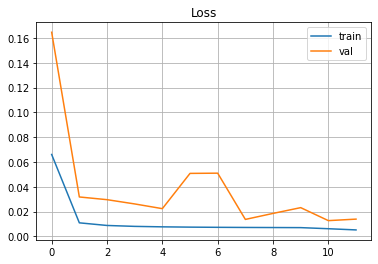

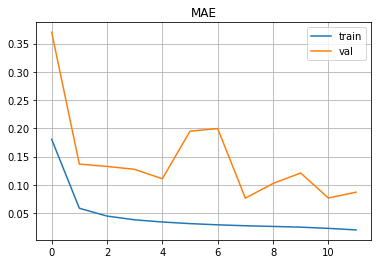

In [ ]:
# plot loss
plt.plot( history.history['loss'],'',  history.history['val_loss'],'-')
plt.title('Loss')
plt.legend(['train','val'])
plt.grid()
plt.show()
# plot mae
plt.plot(history.history['mae'],'', history.history['val_mae'],'-')
plt.title('MAE')
plt.legend(['train','val'])
plt.grid()
plt.show()
